In [1]:
import pandas as pd
import os.path
import os
import h5py
import copy
import numpy as np
import tqdm
import itertools
import joblib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm, Normalize


from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.empty_cache()

In [2]:
AFGRUNDIR = "/media/vsevolod/T7/work/prj_kn_afterglow/"
sim = {}; sim["name"] = "SFHoTim276_13_14_0025_150mstg_B0_HLLC"
collated_file_path = AFGRUNDIR + sim["name"] + '/' + "collated.csv"

assert os.path.isfile(collated_file_path), "Collated file not found"
df = pd.read_csv(collated_file_path, index_col=0)
print(f"File loaded: {collated_file_path} {print(df.info(memory_usage='deep'))}")

features_names = [col for col in list(df.columns) if col not in ["flux"]] # here time is included


<class 'pandas.core.frame.DataFrame'>
Index: 6480000 entries, 0 to 6479999
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   eps_e      float64
 1   eps_b      float64
 2   eps_t      float64
 3   p          float64
 4   theta_obs  float64
 5   n_ism      float64
 6   freq       float64
 7   time       float64
 8   flux       float64
dtypes: float64(9)
memory usage: 494.4 MB
None
File loaded: /media/vsevolod/T7/work/prj_kn_afterglow/SFHoTim276_13_14_0025_150mstg_B0_HLLC/collated.csv None


In [3]:
def _visualize_df(df:pd.DataFrame, name:str):
    print(f"\t> Visualizing {name} Shape: {df.shape}")

    display(df.head(2))

    print(f"\t Duplicated_rows: {df.duplicated().sum()}")

    # check df properties
    def analyze_df(df : pd.DataFrame)->pd.DataFrame:
        res = pd.DataFrame({
            "is_unique": df.nunique() == len(df),
            "unique": df.nunique(),
            "with_nan":df.isna().any(),
            "percent_nan":round((df.isnull().sum()/len(df))*100,4),
            "min":df.min(),
            "max":df.max(),
            "mean":df.mean(),
            "dtype":df.dtypes
        })
        return res
    print(f"\t> Numeric features: {df.select_dtypes(exclude='object').shape[1]} \n"
          f"{df.select_dtypes(exclude='object').keys()}")
    print(f"\t> Object features: {df.select_dtypes(exclude='number').shape[1]} \n"
          f"{df.select_dtypes(exclude='number').keys()}")
    print(f"\t Analyzing {name} Summary:")
    metadata = analyze_df(df=df)
    return metadata
metadata = _visualize_df(df=df, name=sim["name"])
display(metadata)

# Print total number of lightcurves
n_curves = np.prod([metadata["unique"][key] for key in df.columns if key not in ["flux","time"]])
n_times = metadata["unique"]["time"]
print(f"total number of light curves: {n_curves} times: {n_times}")

	> Visualizing SFHoTim276_13_14_0025_150mstg_B0_HLLC Shape: (6480000, 9)


,eps_e,eps_b,eps_t,p,theta_obs,n_ism,freq,time,flux
0,0.001,0.001,0.01,2.2,0.0,0.001,2.400000e+09,100000.000000,7.278929e-11
1,0.001,0.001,0.01,2.2,0.0,0.001,2.400000e+09,106332.657164,8.460537e-11


	 Duplicated_rows: 0
	> Numeric features: 9 
Index(['eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq', 'time',
       'flux'],
      dtype='object')
	> Object features: 0 
Index([], dtype='object')
	 Analyzing SFHoTim276_13_14_0025_150mstg_B0_HLLC Summary:


,is_unique,unique,with_nan,percent_nan,min,max,mean,dtype
eps_e,False,5,False,0.0,1.000000e-03,5.000000e-01,1.322000e-01,float64
eps_b,False,5,False,0.0,1.000000e-03,5.000000e-01,1.322000e-01,float64
eps_t,False,4,False,0.0,1.000000e-02,1.000000e+00,4.025000e-01,float64
p,False,4,False,0.0,2.200000e+00,2.800000e+00,2.500000e+00,float64
theta_obs,False,3,False,0.0,0.000000e+00,1.570796e+00,7.853982e-01,float64
n_ism,False,6,False,0.0,1.000000e-03,1.000000e+00,2.768333e-01,float64
freq,False,6,False,0.0,2.400000e+09,9.300000e+10,3.123333e+10,float64
time,False,150,False,0.0,1.000000e+05,9.404449e+08,1.052639e+08,float64
flux,True,6480000,False,0.0,4.115669e-13,1.015367e+02,1.489473e-01,float64


total number of light curves: 43200 times: 150


# Prepare Data for decision trees models

In [4]:
X = df.copy()
y = np.array( X.loc[:,"flux"] )
X = np.array( X.loc[:,features_names] )
# NOTE these are not light curves, these are just fluxes
print(f"X shape: {X.shape}, y shape={y.shape}")

X shape: (6480000, 8), y shape=(6480000,)


In [5]:
def fit_random_forest(X:np.ndarray,
                      y:np.ndarray):
    rf = RandomForestRegressor(
        n_estimators=400,
        n_jobs=-1,
        min_samples_leaf = 20,
        oob_score=True, # out-of-bag (OOB) score, which estimates the model’s generalization performance.
        random_state = 42)
    rf.fit(X, y)
    return rf
rf = fit_random_forest(X,y)
joblib.dump(rf, "./models/trees/rf0.joblib") # compress=0

In [ ]:
rf = joblib.load("./models/trees/rf0.joblib")

In [6]:
# Access the OOB Score
oob_score = rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Making predictions on the same data or new data
predictions = rf.predict(X)

# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.9960755748135831
Mean Squared Error: 0.007330153245277571
R-squared: 0.9966360163114022


In [22]:
def inference(rf, req_pars:dict, times):
    req_pars["time"] = 0.
    pars = [req_pars[key] for key in df.keys() if not key in ["flux"]] # to preserve the order for inference
    _pars = np.vstack(([np.array(pars) for _ in range(len(times))]))
    _pars[:,-1] = times
    pred = rf.predict( _pars )
    return pred

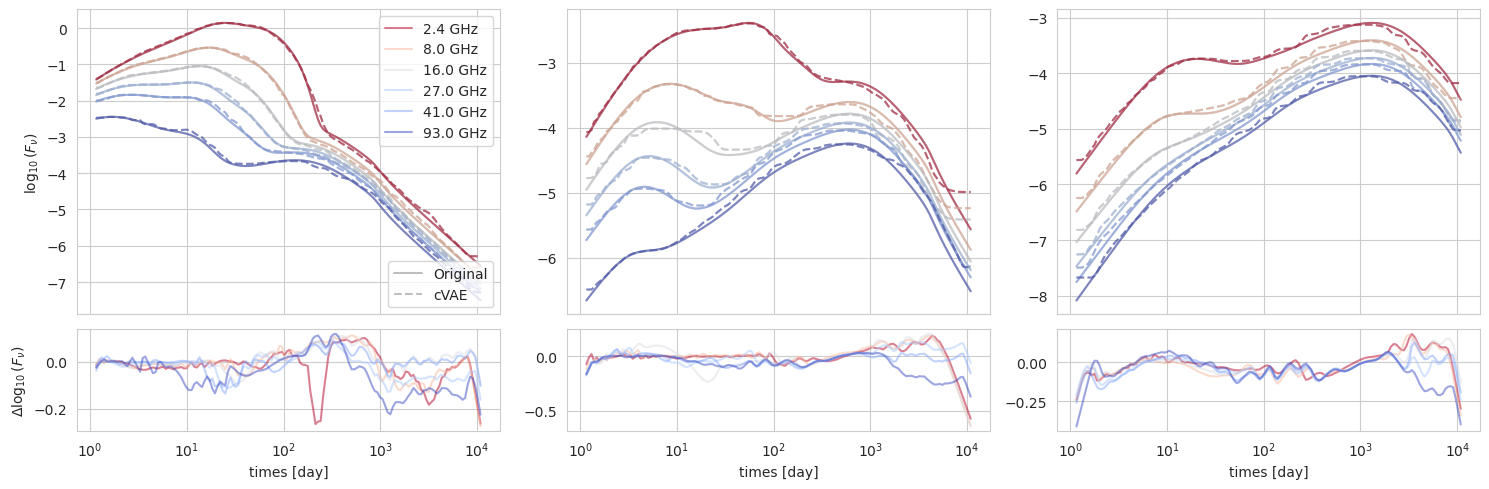

In [23]:
def plot_lcs(tasks, rf, df):
    times = np.array(df["time"].unique())
    freqs = np.unique(np.array(df.loc[:,"freq"]))
    norm = LogNorm(vmin=np.min(freqs),
                   vmax=np.max(freqs))
    cmap_name = "coolwarm_r" # 'coolwarm_r'
    cmap = plt.get_cmap(cmap_name)

    fig, axes = plt.subplots(2,3, figsize=(15,5), sharex='all',
                             gridspec_kw={'height_ratios': [3, 1]})
    
    
    
    for i, task in enumerate(tasks):
        # pars = [req_pars[feat] for feat in features_names]
        l2s = []
        for freq in freqs:
            req_pars = copy.deepcopy(task["pars"])
            req_pars["freq"] = freq
            
            # Create a boolean mask based on the dictionary
            mask = pd.Series(True, index=df.index)
            for col, value in req_pars.items():
                i_mask = df[col] == value
                mask = mask & i_mask
                # if np.sum(mask.astype(int)) == 0:
                #     print(f"Error col={col} val={value}")
                #     return 0
            # print(np.array(df["flux"][mask]))
            # get light curve from training data
            lc = np.log10( np.array(df["flux"][mask]) ).flatten()
         
            
            
            assert len(lc) == len(times), " size mismatch for lc"
            # 
            # 
            l11, = axes[0, i].plot(times/86400, lc,ls='-', color='gray', alpha=0.5, label=f"Original") # for second legend
            l21, = axes[0, i].plot(times/86400, lc,ls='-', color=cmap(norm(freq)), alpha=0.5, label=f"{freq/1e9:.1f} GHz")
            l2s.append(l21)
            
            # # get light curve from model
            lc_nn = np.log10( inference(rf, req_pars, times) )

            # lc_nn = np.zeros_like(times)
            # for it, time in enumerate(times):
            #     req_pars["time"] = time
            #     pars =[req_pars[key] for key in df.keys() if not key in ["flux"]] # to preserve the order for inference
            #     pred = rf.predict( np.array(pars).reshape(1,-1) )
            #     lc_nn[it] = float(pred)
            # lc_nn = np.log10(lc_nn)
            l12, = axes[0, i].plot(times/86400, lc_nn,ls='--', color='gray', alpha=0.5, label=f"cVAE") # for second legend
            l22, = axes[0, i].plot(times/86400, lc_nn,ls='--', color=cmap(norm(freq)), alpha=0.5)


            # plot difference
            axes[1, i].plot(times/86400, lc-lc_nn, ls='-', color=cmap(norm(freq)), alpha=0.5)
            del mask
        axes[0, i].set_xscale("log")
        axes[1, i].set_xlabel(r"times [day]")

    axes[0,0].set_ylabel(r'$\log_{10}(F_{\nu})$')
    axes[1,0].set_ylabel(r'$\Delta\log_{10}(F_{\nu})$')

    first_legend = axes[0,0].legend(handles=l2s, loc='upper right')

    axes[0,0].add_artist(first_legend)
    axes[0,0].legend(handles=[l11,l12], loc='lower right')

    plt.tight_layout()
    plt.show()
tasks = [
    {"pars":{"eps_e":0.001,"eps_b":0.01,"eps_t":1.,"p":2.2,"theta_obs":0.,"n_ism":1e0}, "all_freqs":True},
    {"pars":{"eps_e":0.01,"eps_b":0.01,"eps_t":1.,"p":2.2,"theta_obs":0.,"n_ism":0.01}, "all_freqs":True},
    {"pars":{"eps_e":0.1,"eps_b":0.01,"eps_t":1.,"p":2.2,"theta_obs":0.,"n_ism":0.001}, "all_freqs":True},
]
plot_lcs(tasks, rf, df)

In [48]:
# compute lightcurves for train data
# def compute_all_nn_lcs(rf):
#     times = np.array(df["time"].unique())
#     res = np.empty
#     for 
#     
#     return np.vstack((
#         [inference(rf, req_pars, times) for j in range(len(pars[:,0]))]
#     ))
# nn_lcs = compute_all_nn_lcs()
# print(f"lcs={lcs.shape} nn_lcs={nn_lcs.shape}")
times = np.array(df["time"].unique())
lcs = np.reshape(y, newshape=(len(y)//len(times),len(times)))

yhat = rf.predict(X)
lcs_nn = np.reshape(yhat, newshape=(len(yhat)//len(times),len(times)))

allfreqs = np.reshape(df["freq"], newshape=(len(df["freq"])//len(times),len(times)))

print(f"lcs={lcs.shape} lcs_nn={lcs_nn.shape} freq={allfreqs.shape}")
# nn_lcs = rf.predict(X)

lcs=(43200, 150) lcs_nn=(43200, 150) freq=(43200, 150)


(43200, 150)


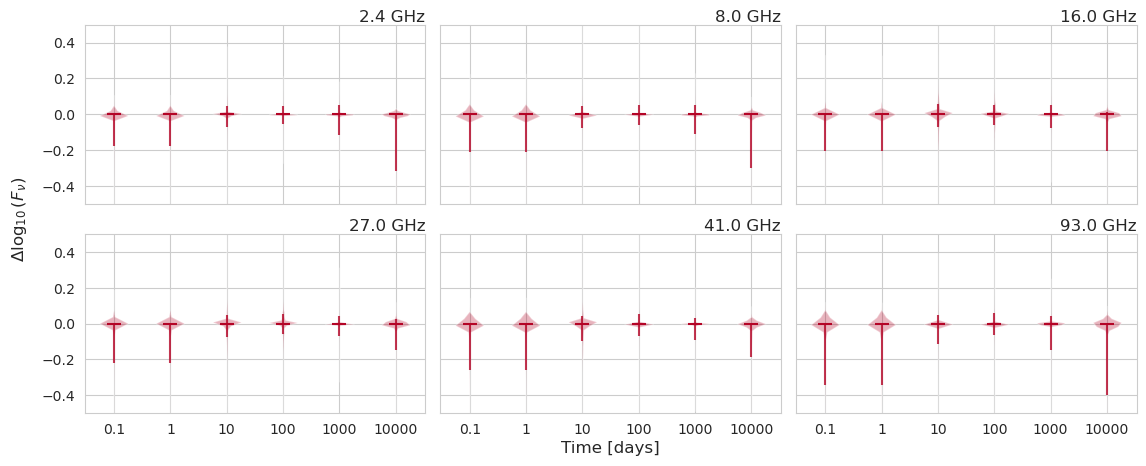

In [56]:
# Plot Violin
def find_nearest_index(array, value):
    ''' Finds index of the value in the array that is the closest to the provided one '''
    idx = (np.abs(array - value)).argmin()
    return idx
def plot_violin():
    cmap_name = "coolwarm_r" # 'coolwarm_r'
    cmap = plt.get_cmap(cmap_name)

    freqs = np.array(df["freq"].unique())
    times = np.array(df["time"].unique())
    norm = LogNorm(vmin=np.min(freqs),
                   vmax=np.max(freqs))

    req_times = np.array([0.1, 1., 10., 100., 1000., 1e4]) * 86400.

    log_lcs = np.log10(lcs)
    log_nn_lcs = np.log10(lcs_nn)
    delta = log_lcs - log_nn_lcs
    print(delta.shape)

    fig, ax = plt.subplots(2, 3, figsize=(12, 5), sharex="all", sharey="all")
    ax = ax.flatten()
    for ifreq, freq in enumerate(freqs):
        i_mask1 = (allfreqs == freq).astype(int)#X[]#(np.array(df["freq"]) == freq).astype(bool)

        _delta = delta * i_mask1
        
        time_indeces = [find_nearest_index(times, t) for t in req_times]
        _delta = _delta[:, time_indeces]
        

        color = cmap(norm(freqs[0]))

        if np.sum(_delta) == 0:
            raise ValueError(f"np.sum(delta) == 0 delta={_delta.shape}")
        # print(_delta.shape)
        violin = ax[ifreq].violinplot(_delta, positions=range(len(req_times)), showextrema=False, showmedians=True)


        for pc in violin['bodies']:
            pc.set_facecolor(color)
        violin['cmedians'].set_color(color)
        for it, t in enumerate(req_times):
            ax[ifreq].vlines(it, np.quantile(_delta[:,it], 0.025), np.quantile(_delta[:,it], 0.975), color=color, linestyle='-', alpha=.8)

        # ax[ifreq].hlines([-1,0,1], 0.1, 6.5, colors='gray', linestyles=['dashed', 'dotted', 'dashed'], alpha=0.5)


        ax[ifreq].set_xticks(np.arange(0, len(req_times)))
        # print(ax[ifreq].get_xticklabels(), ax[ifreq])
        _str = lambda t : '{:.1f}'.format(t/86400.) if t/86400. < 1 else '{:.0f}'.format(t/86400.)
        ax[ifreq].set_xticklabels([_str(t) for t in req_times])

        ax[ifreq].annotate(f"{freq/1e9:.1f} GHz", xy=(1, 1),xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
        
        ax[ifreq].set_ylim(-0.5,0.5)


    # Create the new axis for marginal X and Y labels
    ax = fig.add_subplot(111, frameon=False)

    # Disable ticks. using ax.tick_params() works as well
    ax.set_xticks([])
    ax.set_yticks([])

    # Set X and Y label. Add labelpad so that the text does not overlap the ticks
    ax.set_xlabel(r"Time [days]", labelpad=20, fontsize=12)
    ax.set_ylabel(r"$\Delta \log_{10}(F_{\nu})$", labelpad=40, fontsize=12)

    plt.tight_layout()
    plt.show()

plot_violin()